<a href="https://colab.research.google.com/github/nmermigas/PyTorch/blob/main/08_paper_replicating_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08. PyTorch Paper Replicating

Actual Goal: Turn ML research into ussable code.
We are going to replicate Vision Transformer (ViT) paper. https://arxiv.org/abs/2010.11929

## 0. Get Setup
We are going to use the code from going_modular (05 notebook).

In [28]:
import torch
import torchvision

torch.__version__,torchvision.__version__

('2.1.0+cu118', '0.16.0+cu118')

In [29]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [30]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## 1. Get data

The whole goal is to replicate the ViT architecture for our FoodVision Mini problem.

To do that, we need the data we have been using so far.

In [31]:
# Download pizza, steak, sushi images from Github
image_path = download_data(source ="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [32]:
# Setup directory paths for training and test
train_dir = image_path /'train'
test_dir = image_path /'test'

## 2. Create Datasets and DataLoaders


### 2.1 Create image size, Batch size and transform (manual)


In [33]:
from going_modular.going_modular import data_setup

IMAGE_SIZE = 224 # can be found at table 3 of the ViT paper.
BATCH_SIZE = 32 # in the paper is 4096, but we do not have that much computing power

# Create transforms pipeline
manual_transforms = transforms.Compose([transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
                                        transforms.ToTensor()])
manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)

### 2.2 Create DataLoaders


In [34]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size = BATCH_SIZE
)

len(train_dataloader),len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image.

In [35]:
# iterate through the train_dataloader and visualize one single image
# Get the image batch
image_batch , label_batch = next(iter(train_dataloader))

# Get a single image from the batch

image, label = image_batch[0], label_batch[0]

# View the image and label shapes
image.shape, label.shape

(torch.Size([3, 224, 224]), torch.Size([]))

(-0.5, 223.5, 223.5, -0.5)

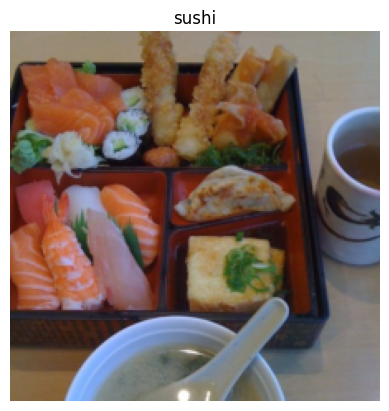

In [36]:
# Plot the image
import matplotlib.pyplot as plt

plt.imshow(image.permute(1,2,0)) # (color_channels, h,w) -> (h,w, color_channels)
plt.title(class_names[label])
plt.axis(False)

### 3. Replicating ViT: Overview

Looking at a whole ML research aper can be intimidating.

So in order to make it more understatable, we break it down into smaller pieces.

* **Inputs** - What goes into the model (in our case, image tensors (batches))
* **Outputs** - What come out of the model/layer/block ? (in our case: Classification labels)
* **Layers** - Takes an input, manipulates it with a function (e.g self-attention)
* **Block** - A collection of layers
* **Model** - A collection of blocks

### 3.1 ViT overview: "gathering the pieces"

* Figure 1: Visual overview of the architecture
* 4 equations: Math equations that define the functions of each layer/block
* Table 1: different hyperparameters for the architecture/training.
* Text

#### Figure 1
<img src = "https://drive.google.com/file/d/1g03SePH4WFA6D5x5qVRX8GXJm853wM8U/open?usp=drive_link" alt = 'figure 1'/>

* Embedding = learning representation (random in the beggining and imporve over time)

#### 4 Equations
<img src='https://drive.google.com/file/d/1S7fXVm0WcGvP8znz8mv_S7aOkm9rXF0B/view?usp=drive_link' />

#### Table 1
<img src ='https://drive.google.com/file/d/1Ql-pUCKl49X2Wxo1dNjIb28OFhs-vI4z/view?usp=drive_link' />



### Table 1

There are 3 models presented in the paper:

* ViT-Base, ViT-Large and ViT-Huge are all different sizes of the same model architecture.
* Layers - the number of transformer encoder layers.
* Hidden size $D$ - the embedding size throughout the architecture
* MLP size -the number of hidden units/neurons in the MLP.
* Head - the number of the multi-head self-attention.

## 4. Equation 1: Split data into patches and creating the class, position and patch embedding.

Layers = input -> function -> output

What's the input shape?

What's the output shape?

### 4.1 Calculating input and output shapes.

* Input shape : (224,224,3) -> single image -> (height,width, color channels)
* Output shape: (
* Input image: $H\times{W}\times{C}$ ((height x width x color channels)
* Output image: $\mathbb{N \times\left(P^{2} \cdot C\right)}$
* H = height
* W = width
* C = color channels
* P = patch size
* N =number of patches = (height * width) /p^2
* D = constant latent vector size = embedding dimension (see table 1)


In [37]:
# Create exampole values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height*width) / patch_size**2)
number_of_patches

196

In [38]:
# Input shape
embedding_layer_input_shape = (height,width,color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f'Input shape (single 2D image): {embedding_layer_input_shape}')
print(f'Output shape (single 1D sequence of patches): {embedding_layer_output_shape} ( number_of_patches, embedding_dimension)')


Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768) ( number_of_patches, embedding_dimension)


(-0.5, 223.5, 223.5, -0.5)

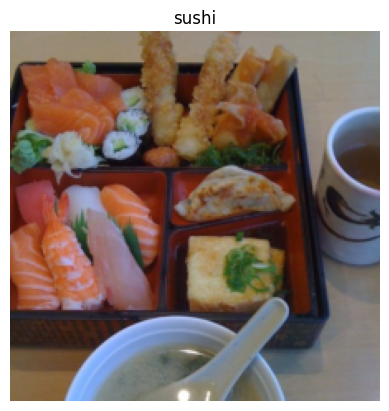

In [39]:
### 4.2 Turning a single image into patches
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [40]:
image.shape

torch.Size([3, 224, 224])

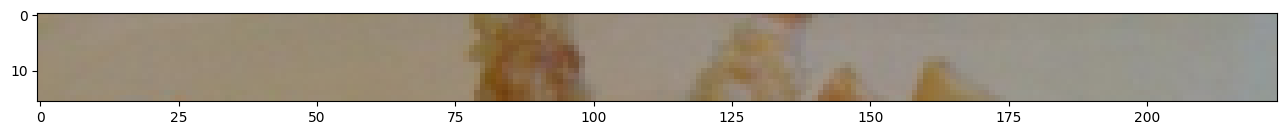

In [41]:
# Get the top row of the image
image_permuted = image.permute(1,2,0) # convert image to cc last (H,W,C)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size,patch_size))
plt.imshow(image_permuted[:patch_size,:,:])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


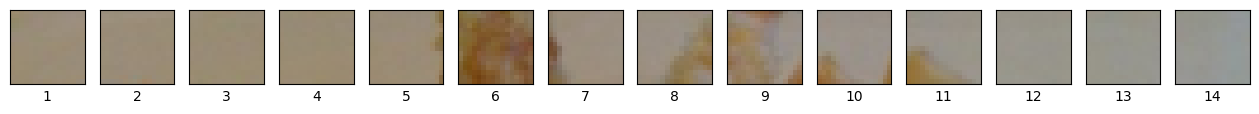

In [42]:
# Setup code to plot row as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f'Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels')

# Create a series of subplots
fig, axs = plt.subplots(nrows = 1,
                        ncols = img_size // patch_size, # one columnn per patch
                        sharex=True,
                        sharey=True,
                        figsize = (patch_size,patch_size))

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size,patch:patch+patch_size,:])
  axs[i].set_xlabel(i+1) # set the patch label
  axs[i].set_xticks([])
  axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


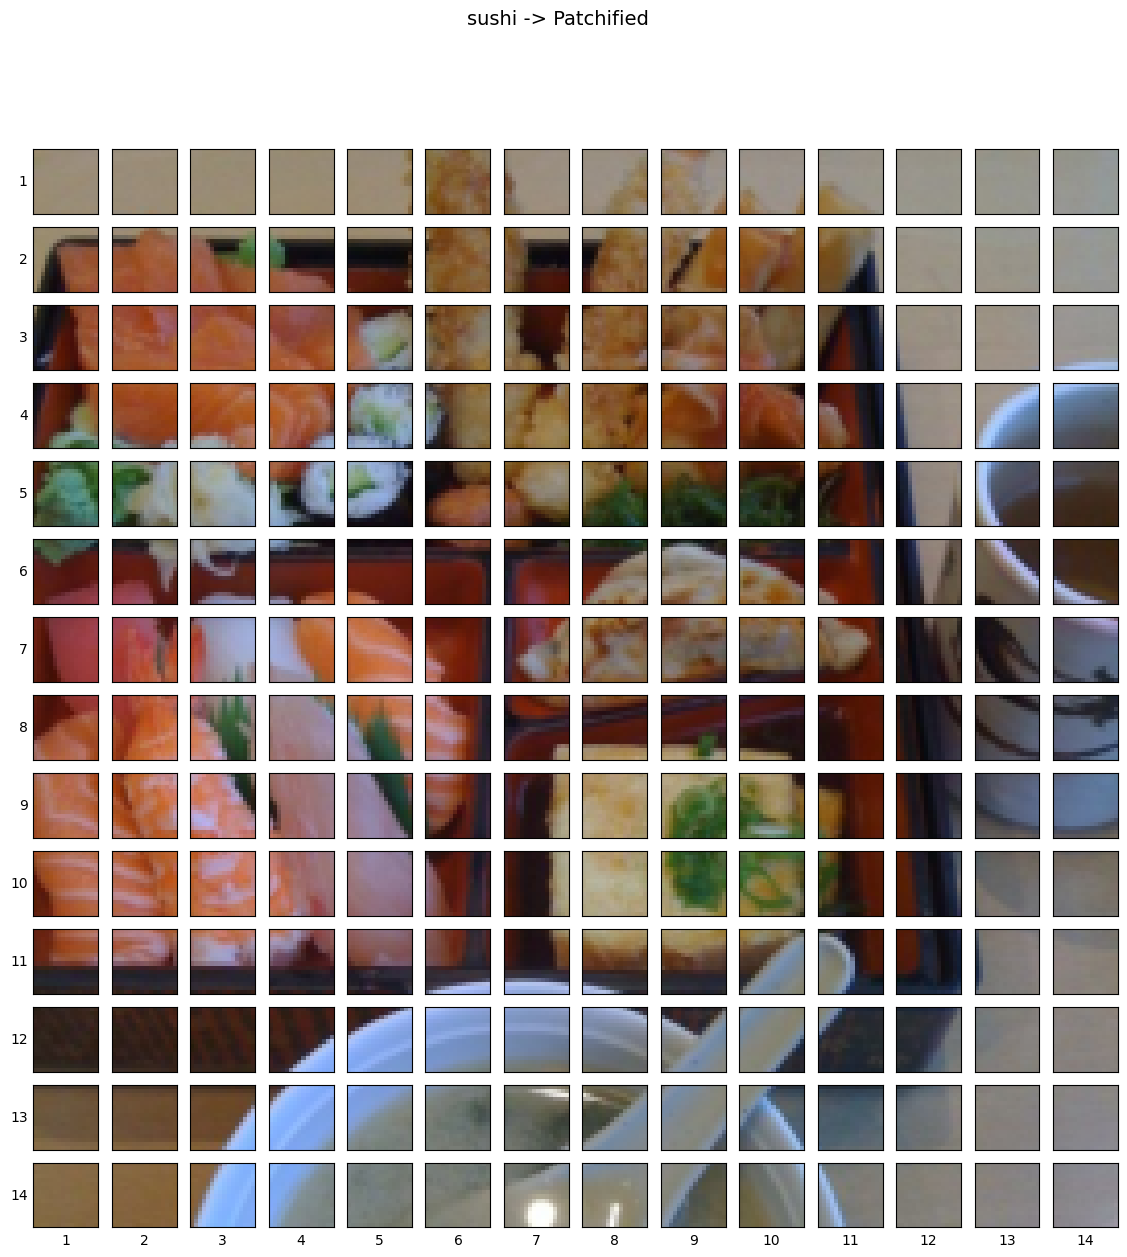

In [43]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=14)
plt.show()


### 4.3 Creating patch embeddings

We will create image patches and image patch embeddings in a single step using `torch.nn.Conv2d()` and setting the kernel size and stride parameters to `patch_size`.

In [44]:
# Create Conv2d layer to turn image into patches of learnable feature maps (embeddings)
from torch import nn

# Set the patch size
patch_size = 16

# Create a Conv2d layer with the hyperparameters from the ViT paper.
conv2d = nn.Conv2d(in_channels = 3, # for color images
                   out_channels = 768, # D size of table 1 of ViT-Base
                   kernel_size = patch_size,
                   stride = patch_size,
                   padding = 0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(-0.5, 223.5, 223.5, -0.5)

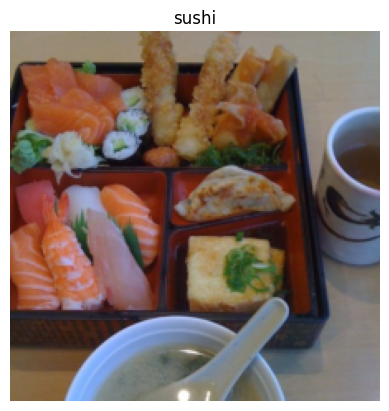

In [45]:
# View single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [46]:
# Pass the image throug the conv2d layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add the batch dimension -> (batch_size,color_channels,height,width)
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

Now we've passed a single image to the `conv2d` layer, it's shape is:

```python
torch.Size([1, 768, 14, 14]) # [batch_size,embedding_dim, feature_map_height, feature_map_width]
```

Showing random convolutional feature maps from indexes: [460, 407, 614, 26, 327]


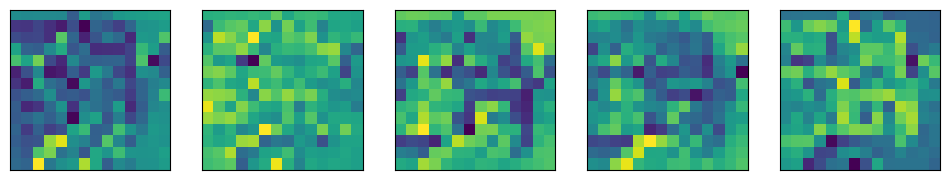

In [47]:
# plot random convolutional feature maps (embeddings)
import random
random_indexes = random.sample(range(0,758),k=5)
print(f'Showing random convolutional feature maps from indexes: {random_indexes}')

# Create plot
fig, axs = plt.subplots(nrows=1,
                        ncols=5,
                        figsize=(12,12))

# Plot random image feature maps
for i,idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:,idx,:,:] # index on the output tensor of the conv2d layer
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) #remove batch dimension, remove from grad tracking/switch to numpy for matplotlyb
  axs[i].set(xticklabels=[],
             yticklabels=[],
             xticks=[],
             yticks=[])


In [49]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:,0,:,:]
single_feature_map.shape,single_feature_map.requires_grad

(torch.Size([1, 14, 14]), True)

### 4.4 Flattening the patch embedding with `torch.nn.Flatten()`

We want to flatten the patch embeddings into a sequence of patch embeddings to satisfy the criteria of the paper.

Want: (batch_size, number_of_patches, embedding_dim)

In [51]:
# Create a Flatten layer.
from torch import nn
flatten_layer = nn.Flatten(start_dim=2,
                           end_dim=-1)
flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


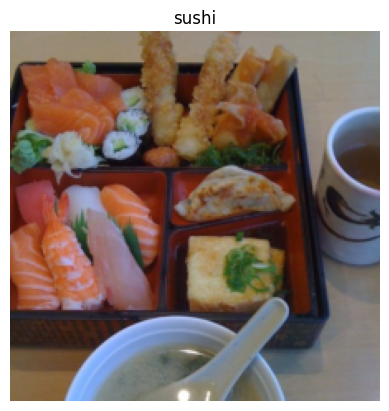

In [52]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
print(f'Original image shape: {image.shape}')

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0))
print(f'Image feature map (patches) shape: {image_out_of_conv.shape}')

# Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f'Flattened image feature map shape: {image_out_of_conv_flattened.shape}')

In [54]:
# Rearrange output of flattened layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0,2,1)
print(f'{image_out_of_conv_flattened.permute(0,2,1).shape}')

torch.Size([1, 196, 768])


(-0.5, 195.5, 0.5, -0.5)

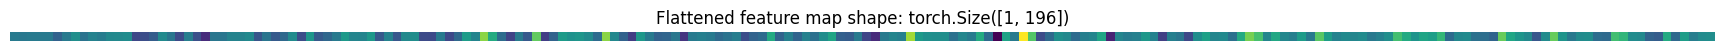

In [56]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:,:,0]

# Plot the flattened feature map
plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f'Flattened feature map shape: {single_flattened_feature_map.shape}')
plt.axis(False)


### 4.5 Turning the ViT patch embedding layer into a PyTorch module

We want this module to:
1. Create a class called `PatchEmbedding`
2. Initialize with appropriate hyperparameters, such as channels, embedding dimension, patch size.
3. Create a layer to turn an image into embedded patches using `nn.Conv2d()`
4. Create a layer to flatten the feature maps of the output of the layer in 3
5. Define a `forward()` that defines the forward computation
6. Make sure the output shape of the layer reflects the required output shape of the patch embedding.

In [63]:
# 1. Create a class PatchEmbedding
class PatchEmbedding(nn.Module):
  # 2. Initialize the layer with appropriate hyperparameters
  def __init__(self,
               in_channels:int = 3,
               patch_size:int = 16,
               embedding_dim:int = 768): # from Table 1 for vit base
    super().__init__()

    # 3. Create a layer to turn an image into embedded patches
    self.patcher = nn.Conv2d(in_channels = in_channels,
                             out_channels=embedding_dim,
                             kernel_size = patch_size,
                             stride = patch_size,
                             padding = 0)
    # 4. Create a layer to flatten feature maps outputs of Conv2d
    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=-1) #the last dimension

  # 5. Define a forward method to define the forward computation steps
  def forward(self,x):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f'Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}'

    # Perform the forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)

    # 6. Make sure the returned sequence embedding dimensions are in the right order
    return x_flattened.permute(0,2,1)


In [64]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim =768)

# Pass a single image through patch embedding layer
print(f'Input Image size: {image.unsqueeze(0).shape}')
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra  batch dim
print(f'Output patch embedding sequence shape: {patch_embedded_image.shape}')

Input Image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])
